In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics


import datetime as dt

import env

import os

In [3]:
# returns a local csv if it exists
if os.path.isfile('curriculum.csv'):
    df = pd.read_csv('curriculum.csv')
else:
    sql = ''' SELECT * 
            FROM logs 
            LEFT JOIN cohorts ON cohorts.id = logs.cohort_id; '''
    url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'
    df = pd.read_sql(sql, url)

    df.to_csv('curriculum.csv')


In [4]:
df

,Unnamed: 0,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
3,3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
4,4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900218,900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.0
900219,900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.0
900220,900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.0
900221,900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  900223 non-null  int64  
 1   date        900223 non-null  object 
 2   time        900223 non-null  object 
 3   path        900222 non-null  object 
 4   user_id     900223 non-null  int64  
 5   cohort_id   847330 non-null  float64
 6   ip          900223 non-null  object 
 7   id          847330 non-null  float64
 8   name        847330 non-null  object 
 9   slack       847330 non-null  object 
 10  start_date  847330 non-null  object 
 11  end_date    847330 non-null  object 
 12  created_at  847330 non-null  object 
 13  updated_at  847330 non-null  object 
 14  deleted_at  0 non-null       float64
 15  program_id  847330 non-null  float64
dtypes: float64(4), int64(2), object(10)
memory usage: 109.9+ MB


# Prep

In [6]:
courses = pd.DataFrame({'program_id':[1, 2, 3, 4], 
                            'course_name':['Web Dev 1', 'Web Dev 2', 'Data Science', 'Cloud'], 
                            'course_subdomain':['php', 'java', 'ds', 'fe']})

# add the course names to the log files
df = df.merge(courses, how='left', left_on='program_id', right_on='program_id')

# drop duplicate columns
df = df.drop(columns=['Unnamed: 0', 'deleted_at'])

# combine string date and time into one column
df['datetime'] = df.date + ' ' + df.time
# convert string type into datetime type
df['datetime'] = pd.to_datetime(df.datetime)
df['start_date'] = pd.to_datetime(df.start_date)
df['end_date'] = pd.to_datetime(df.end_date)

# set index to datetime
df = df.set_index('datetime').sort_index()

# since the datetime object came from a string, we don't know the timezone
df = df.tz_localize('America/Chicago', ambiguous=True)
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name() 

In [7]:
# Function to classify based on program_id
def classify_program(program_id):
    if program_id == 1:
        return "Web Dev"
    elif program_id == 2:
        return "Web Dev 2"
    elif program_id == 3:
        return "Data Science"
    else:
        return "Cloud"

# Create a new 'Category' column based on the program_id classification
df['Category'] = df['program_id'].apply(classify_program)

df

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday,Category
datetime,,,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03-06:00,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:02-06:00,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:05-06:00,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:06-06:00,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:24-06:00,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Web Dev 2,java,9,Friday,Web Dev 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51-05:00,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Web Dev 2,java,16,Wednesday,Web Dev 2
2021-04-21 16:42:02-05:00,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Web Dev 2,java,16,Wednesday,Web Dev 2
2021-04-21 16:42:09-05:00,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Web Dev 2,java,16,Wednesday,Web Dev 2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03-06:00 to 2021-04-21 16:44:39-05:00
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              900223 non-null  object        
 1   time              900223 non-null  object        
 2   path              900222 non-null  object        
 3   user_id           900223 non-null  int64         
 4   cohort_id         847330 non-null  float64       
 5   ip                900223 non-null  object        
 6   id                847330 non-null  float64       
 7   name              847330 non-null  object        
 8   slack             847330 non-null  object        
 9   start_date        847330 non-null  datetime64[ns]
 10  end_date          847330 non-null  datetime64[ns]
 11  created_at        847330 non-null  object        
 12  updated_at        847330 non-null  object        
 13  program_id   

# Explore

# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

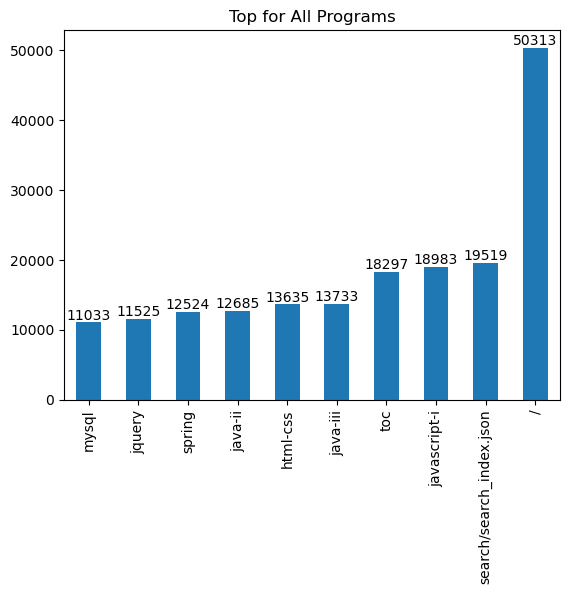

In [9]:
# most traffic across all programs
# Assuming you have a DataFrame 'df' and you want to plot the top 10 paths
top_paths = df['path'].value_counts().sort_values().tail(10)

# Create the bar plot
ax = top_paths.plot(kind='bar', title='Top for All Programs')

# Annotate the bars with their respective counts
for i, v in enumerate(top_paths):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.show()

In [10]:
# Assuming you have a DataFrame 'df' with program information
web_dev_1_df = df[(df['program_id'] == 1) & (df['path'] != "/") & (df['path'] !="index.html")]  # Assuming '1' is the program_id for "Web Dev"
most_popular_path_web_dev_1 = web_dev_1_df['path'].value_counts().idxmax()

print("The most popular path for Web Dev 1 (excluding '/') is:", most_popular_path_web_dev_1)


The most popular path for Web Dev 1 (excluding '/') is: javascript-i


In [11]:
# Assuming you have a DataFrame 'df' with program information
web_dev_2_df = df[(df['program_id'] == 2) & (df['path'] != "/") & (df['path'] !="index.html")]  # Assuming '1' is the program_id for "Web Dev"
most_popular_path_web_dev_2 = web_dev_2_df['path'].value_counts().idxmax()

print("The most popular path for Web Dev 2 (excluding '/') is:", most_popular_path_web_dev_2)

The most popular path for Web Dev 2 (excluding '/') is: javascript-i


In [12]:
# Assuming you have a DataFrame 'df' with program information
data_science_df = df[(df['program_id'] == 3) & (df['path'] != "/") & (df['path'] != "search/search_index.json")]  # Assuming '1' is the program_id for "Web Dev"
most_popular_path_data_science = data_science_df['path'].value_counts().idxmax()

print("The most popular path for data_science (excluding '/') is:", most_popular_path_data_science)


The most popular path for data_science (excluding '/') is: classification/overview


In [13]:
# Assuming you have a DataFrame 'df' with program information
cloud_df = df[(df['program_id'] == 4) & (df['path'] != "/") & (df['path'] != "search/search_index.json")]  # Assuming '1' is the program_id for "Web Dev"
most_popular_path_cloud = cloud_df['path'].value_counts().idxmax()

print("The most popular path for cloud (excluding '/') is:", most_popular_path_cloud)


The most popular path for cloud (excluding '/') is: content/html-css


# 7. Which lessons are least accessed?

In [14]:
# Assuming you have a DataFrame 'df' with program information
cloud_df = df[(df['program_id'] == 4) & (df['path'] != "/") & (df['path'] != "search/search_index.json")]

# Find the least accessed paths for the 'cloud' program
least_accessed_paths = cloud_df['path'].value_counts().nsmallest(10)

print("The least accessed paths for the 'cloud' program (excluding '/' and 'search/search_index.json') are:")
print(least_accessed_paths)


The least accessed paths for the 'cloud' program (excluding '/' and 'search/search_index.json') are:
content/html-css/gitbook/images/favicon.ico    1
content/html-css/introduction.html             1
content/html-css                               2
Name: path, dtype: int64


In [15]:
# Assuming you have a DataFrame 'df' with program information
data_science_df = df[(df['program_id'] == 3) & (df['path'] != "/") & (df['path'] != "search/search_index.json")]

# Find the least accessed paths for the 'cloud' program
least_accessed_paths = data_science_df['path'].value_counts().nsmallest(10)

print("The least accessed paths for the 'data science' program (excluding '/' and 'search/search_index.json') are:")
print(least_accessed_paths)

The least accessed paths for the 'data science' program (excluding '/' and 'search/search_index.json') are:
tidy-data                                 1
2-storytelling/1-overview/www.qlik.com    1
decision-trees                            1
java-i/console-io                         1
classification/knn.md                     1
12-distributed-ml/5-inspect               1
index.html                                1
acquire-and-prep                          1
storytelling/creating-custom-fields.md    1
creating-charts                           1
Name: path, dtype: int64


In [16]:
# Assuming you have a DataFrame 'df' with program information
web_dev_2_df = df[(df['program_id'] == 2) & (df['path'] != "/") & (df['path'] != "search/search_index.json")]

# Find the least accessed paths for the 'cloud' program
least_accessed_paths = web_dev_2_df['path'].value_counts().nsmallest(10)

print("The least accessed paths for the 'web dev 2' program (excluding '/' and 'search/search_index.json') are:")
print(least_accessed_paths)

The least accessed paths for the 'web dev 2' program (excluding '/' and 'search/search_index.json') are:
extra-features                       1
javascript/apendix                   1
appendix/spring/authorization        1
9.5_DBSCAN_to_detect_anomalies.md    1
spring/integration-tests             1
jquery/whack-a-mole                  1
9_Appendix_Isolation_Forest          1
asset-manifest.json                  1
4-stats/2.4-power-analysis           1
elements/html                        1
Name: path, dtype: int64


In [17]:
# Assuming you have a DataFrame 'df' with program information
web_dev_1_df = df[(df['program_id'] == 2) & (df['path'] != "/") & (df['path'] != "search/search_index.json")]

# Find the least accessed paths for the 'cloud' program
least_accessed_paths = web_dev_1_df['path'].value_counts().nsmallest(10)

print("The least accessed paths for the 'web dev 1' program (excluding '/' and 'search/search_index.json') are:")
print(least_accessed_paths)

The least accessed paths for the 'web dev 1' program (excluding '/' and 'search/search_index.json') are:
extra-features                       1
javascript/apendix                   1
appendix/spring/authorization        1
9.5_DBSCAN_to_detect_anomalies.md    1
spring/integration-tests             1
jquery/whack-a-mole                  1
9_Appendix_Isolation_Forest          1
asset-manifest.json                  1
4-stats/2.4-power-analysis           1
elements/html                        1
Name: path, dtype: int64


# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [18]:

user_activity = df.groupby('user_id')['path'].count().reset_index()

# You can set a threshold for low activity, e.g., less than 5 page views
low_activity_users = user_activity[user_activity['path'] < 15]

In [23]:
len(df.user_id.unique())

981

In [24]:
df.groupby('user_id')['path'].count().reset_index()

,user_id,path
0,1,7404
1,2,1541
2,3,1562
3,4,692
4,5,1701
...,...,...
976,977,86
977,978,55
978,979,127
979,980,3


In [26]:
low_activity_date = df[df['user_id'].isin(low_activity_users['user_id'])]

In [27]:
df

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday,Category
datetime,,,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03-06:00,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:02-06:00,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:05-06:00,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:06-06:00,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:24-06:00,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Web Dev 2,java,9,Friday,Web Dev 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51-05:00,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Web Dev 2,java,16,Wednesday,Web Dev 2
2021-04-21 16:42:02-05:00,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Web Dev 2,java,16,Wednesday,Web Dev 2
2021-04-21 16:42:09-05:00,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Web Dev 2,java,16,Wednesday,Web Dev 2


# 5. At some point in 2019, the ability for students and alumni to access both curricula (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [19]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday,Category
datetime,,,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03-06:00,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:02-06:00,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:05-06:00,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:06-06:00,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Web Dev 1,php,9,Friday,Web Dev
2018-01-26 09:56:24-06:00,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Web Dev 2,java,9,Friday,Web Dev 2


In [20]:
j = df[df.path.str.contains('java', case = False) == True]

In [21]:
j[j.course_name == 'Data Science'].sort_index(ascending= False).head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday,Category
datetime,,,,,,,,,,,,,,,,,,,
2020-05-19 16:03:32-05:00,2020-05-19,16:03:32,java-ii/object-oriented-programming,590,55.0,130.45.47.56,55.0,Curie,#curie,2020-02-03,2020-07-07,2020-02-03 19:31:51,2020-02-03 19:31:51,3.0,Data Science,ds,16,Tuesday,Data Science
2019-12-14 16:46:24-06:00,2019-12-14,16:46:24,javascript-i,476,34.0,136.50.49.145,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,ds,16,Saturday,Data Science
2019-12-03 11:49:35-06:00,2019-12-03,11:49:35,java-ii,467,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,ds,11,Tuesday,Data Science
2019-12-03 11:49:33-06:00,2019-12-03,11:49:33,javascript-ii,467,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,ds,11,Tuesday,Data Science
2019-12-03 11:49:29-06:00,2019-12-03,11:49:29,javascript-i,467,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,Data Science,ds,11,Tuesday,Data Science


# 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?


In [22]:

# Identify graduates by filtering for records where the 'end_date' is not null
graduates = df[df['end_date'].notnull()]

# Exclude paths equal to "/"
graduates = graduates[graduates['path'] != "/"]

# Analyze post-graduation behavior for each program
post_graduation_behavior = graduates.groupby('program_id')['path'].value_counts().reset_index(name='access_count')

# Find the most accessed topics after graduation for each program
most_accessed_topics = post_graduation_behavior.groupby('program_id').apply(lambda x: x[x['access_count'] == x['access_count'].max()]).reset_index(drop=True)

# Display the results
print("Most accessed topics after graduation for each program:")
print(most_accessed_topics)


Most accessed topics after graduation for each program:
   program_id                      path  access_count
0         1.0                index.html          1011
1         2.0              javascript-i         17457
2         3.0  search/search_index.json          2203
3         4.0          content/html-css             2
